# Проект: Статистический анализ данных
Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

1. без подписки
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

2. с подпиской Ultra
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st

# Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv') # загружаем датафрейм с информацией о пользователях
rides = pd.read_csv('/datasets/rides_go.csv') # загружаем датафрейм с информацией о поездках
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv') # загружаем датафрейм с информацией о подписках

Изучим таблицы

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Пропущенных значений нет, столбцы названы корректно. Необходимо будет поменять тип даты в столбце date в данных о поездках. Остальные типы по столбцам соответствуют своему назначению.

# Шаг 2. Предобработка данных

Преобразуем столбец date к типу даты pandas.

In [9]:
rides['date'] = pd.to_datetime(rides['date'])
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Создадим новый столбец с номером месяца на основе столбца date.

In [10]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Как уже смотрели ранее пропущенных значений нет. Посмотрим теперь дубликаты. В данных видов тарифов (подписка и без) и так 2 строчки и смотреть бессмысленно.

In [11]:
print('В данных пользователей явных дубликатов:', users.duplicated().sum())
print('В данных поездок явных дубликатов:', rides.duplicated().sum())

В данных пользователей явных дубликатов: 31
В данных поездок явных дубликатов: 0


In [12]:
# удалим явные дубликаты
print('Было (кол-во):', users['user_id'].count())
users = users.drop_duplicates()
print('Осталось явных дубликатов:', users.duplicated().sum()) # проверим выполнение
print('Стало (кол-во)', users['user_id'].count())

Было (кол-во): 1565
Осталось явных дубликатов: 0
Стало (кол-во) 1534


Теперь рассматрим неявные дубликаты.

In [13]:
print(users['user_id'].unique().tolist())
print(users['user_id'].duplicated().unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

Лишних пробелов не замечено, также и явных дубликатов конкретно по столбцу нет. Смотрим дальше.

In [14]:
sorted(users['name'].unique())

['Агата',
 'Аделина',
 'Адель',
 'Айдар',
 'Александр',
 'Александра',
 'Алексей',
 'Алина',
 'Алиса',
 'Алия',
 'Алла',
 'Альберт',
 'Альбина',
 'Алёна',
 'Амалия',
 'Амина',
 'Амир',
 'Анастасия',
 'Анатолий',
 'Ангелина',
 'Андрей',
 'Анжелика',
 'Анна',
 'Антон',
 'Антонина',
 'Ариана',
 'Арина',
 'Арсен',
 'Арсений',
 'Артемий',
 'Артур',
 'Артём',
 'Богдан',
 'Борис',
 'Вадим',
 'Валентина',
 'Валерий',
 'Валерия',
 'Варвара',
 'Василий',
 'Василина',
 'Василиса',
 'Вера',
 'Вероника',
 'Виктор',
 'Виктория',
 'Виолетта',
 'Виталий',
 'Виталина',
 'Влад',
 'Влада',
 'Владимир',
 'Владислав',
 'Владислава',
 'Всеволод',
 'Вячеслав',
 'Галина',
 'Георгий',
 'Герман',
 'Глеб',
 'Гордей',
 'Григорий',
 'Давид',
 'Дамир',
 'Даниил',
 'Данил',
 'Данила',
 'Даниэль',
 'Дарина',
 'Дарья',
 'Демид',
 'Денис',
 'Диана',
 'Дмитрий',
 'Ева',
 'Евгений',
 'Евгения',
 'Егор',
 'Екатерина',
 'Елена',
 'Елизавета',
 'Елисей',
 'Есения',
 'Жанна',
 'Зарина',
 'Захар',
 'Злата',
 'Иван',
 'Игнат',

In [15]:
print(sorted(users['age'].unique()))

[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43]


In [16]:
sorted(users['city'].unique())

['Екатеринбург',
 'Краснодар',
 'Москва',
 'Омск',
 'Пятигорск',
 'Ростов-на-Дону',
 'Сочи',
 'Тюмень']

In [17]:
print(rides['user_id'].unique().tolist())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

Неявных дубликатов не обнаружено. Явно данные вводятся либо из выпадающих списков или что-то типо того либо проходят доп проверку (в случае с именем). Но спасибо тому кто предоставил красивые данные.

##### Вывод

Был изменен тип столбца date в данных о поездках, создан столбец "Номер месяца". Было найдено 31 явных дубликатов строк в данных о пользователях, очищено. В остальном могу сказать только спасибо за красиво собранные данные!

# Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

In [18]:
city_num = (
    users.groupby('city', as_index=False)
    .size()
    .rename(columns={'city': 'Город', 
                     'size': 'Количество'})
    .sort_values(by='Количество', ascending=False)
)
city_num

,Город,Количество
4,Пятигорск,219
0,Екатеринбург,204
5,Ростов-на-Дону,198
1,Краснодар,193
6,Сочи,189
3,Омск,183
7,Тюмень,180
2,Москва,168


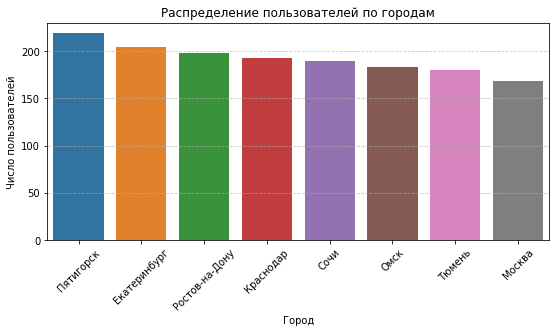

In [19]:
plt.figure(figsize=(9,4))
sns.barplot(data=city_num, x='Город', y='Количество')
plt.title('Распределение пользователей по городам')
plt.ylabel('Число пользователей')
plt.xlabel('Город')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

###### Вывод

Топ-3 городов по кол-ву пользователей: Пятигорск, Екатеринбург, Ростов-на-Дону. Меньше всего пользователей из Москвы.

##### Соотношение пользователей с подпиской и без подписки

In [20]:
user_type = (
    users.groupby('subscription_type', as_index=False)
    .size()
    .rename(columns={'subscription_type': 'Тип подписки',
                     'size': 'Количество'})
)
user_type

,Тип подписки,Количество
0,free,835
1,ultra,699


In [21]:
total_users = user_type['Количество'].sum()
sub = user_type.loc[user_type['Тип подписки'] == 'ultra', 'Количество'].values[0]
unsub = user_type.loc[user_type['Тип подписки'] == 'free', 'Количество'].values[0]

print(f"Доля пользователей с подпиской: {sub / total_users:.2%}")
print(f"Доля пользователей без подписки: {unsub / total_users:.2%}")

Доля пользователей с подпиской: 45.57%
Доля пользователей без подписки: 54.43%


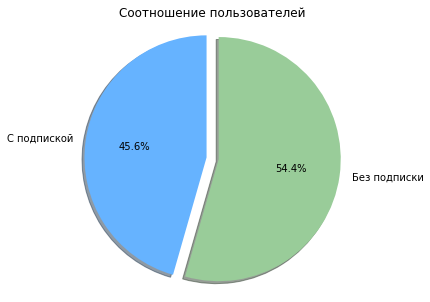

In [22]:
labels = ['С подпиской', 'Без подписки']
sizes = [sub, unsub]
colors = ['#66b3ff', '#99cc99']
explode = (0.1, 0)

plt.figure(figsize=(7, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Соотношение пользователей')
plt.show()

Больше бесплатных пользователей, но количество пользователей с подпиской тоже не сильно уступает.

##### Возраст пользователей

In [23]:
age_users = (
    users.groupby('age', as_index=False)
    .size()
    .rename(columns={'age': 'Возраст',
                     'size': 'Количество'})
    .sort_values(by='Количество', ascending=False)
)
age_users

,Возраст,Количество
13,25,145
12,24,132
14,26,131
11,23,129
15,27,119
10,22,119
16,28,112
9,21,93
8,20,71
18,30,68


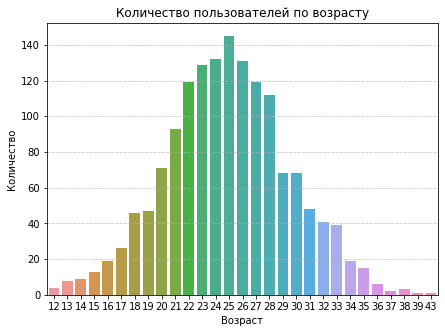

In [24]:
plt.figure(figsize=(7, 5))
sns.barplot(data=age_users, x='Возраст', y='Количество')
plt.title('Количество пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

###### Вывод

По графику сразу видно, что большая часть пользователей сервиса аренды самокатов это люди от 20 до 30 лет. Наибольшая популярность у молодежи, особенно среди тех, кому 23-26 лет.

##### Расстояние, которое пользователь преодолел за одну поездку

In [25]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

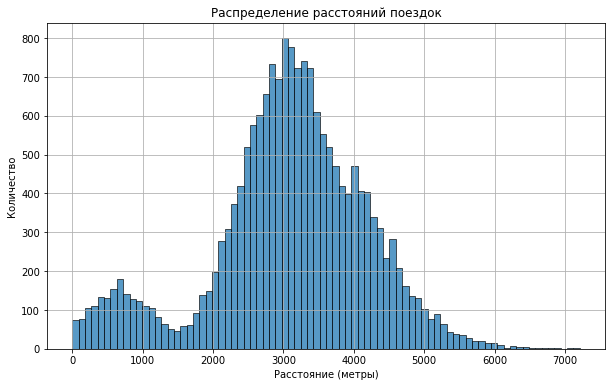

In [26]:
plt.figure(figsize=(10,6))
sns.histplot(rides['distance'], bins=80)
plt.title('Распределение расстояний поездок')
plt.xlabel('Расстояние (метры)')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

###### Вывод

Большее кол-во поездок совершается на расстояние от 2 до 4 км это значит, что пользователи используют самокаты чаще всего для коротких и средних дистанций (например, в масштабах Екатеринбурга это как проехать район). Разброс данных небольшой (среднее и медиана очень близки друг к другу).

##### Продолжительность поездок

In [27]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

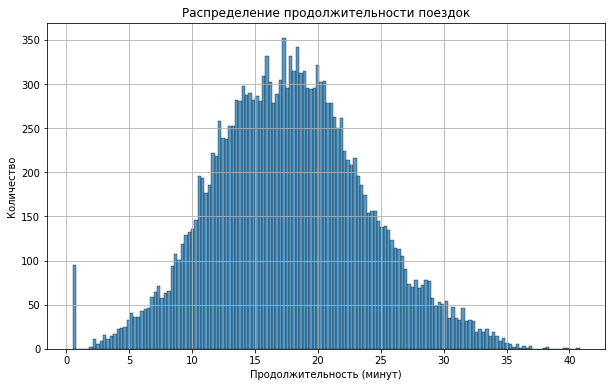

In [28]:
plt.figure(figsize=(10,6))
sns.histplot(rides['duration'], bins=150)
plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность (минут)')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

###### Вывод

Большинство поездок в диапазоне 13-23 мин. Это может говорить нам о том, что пользуются самокатами в большей степени для средних поездок. Есть интересный скачок данных на 1 мин (до 100 наблюдений) это, возможно, говорит нам о сбое во взаимодействии с самокатами (например, батарея не заряжена у самоката, или подключались чтобы передвинуть ближе к стоянке, может не смог найти стоянку в том месте куда планировал поехать).

# Шаг 4. Объединение данных

In [29]:
# соединяем users и rides
df = pd.merge(users, rides, on='user_id', how='inner') # используем inner чтобы остались только те пользователи, у которых есть поездки
# объединяем с subscriptions
df = pd.merge(df, subscriptions, on='subscription_type', how='left')
df.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [30]:
print(f"Количество строк в rides: {rides.shape[0]}") # проверяем по нему, т.к. он "центр" объединения.
print(f"Количество строк в df: {df.shape[0]}")
print()
print(f"Количество столбцов до объединения: {rides.shape[1] + users.shape[1] + subscriptions.shape[1]}") # -2 потому что 2 столбца повторяются
print(f"Количество строк после объединения: {df.shape[1]}")

Количество строк в rides: 18068
Количество строк в df: 18068

Количество столбцов до объединения: 14
Количество строк после объединения: 12


Создадим 2 датафрейма с пользователями с подпиской и без нее.

In [31]:
df_free = df[df['subscription_type'] == 'free'] # пользователи без подписки
df_free.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,6,8,50,0


In [32]:
df_ultra = df[df['subscription_type'] == 'ultra'] # пользователи с подпиской
df_ultra.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


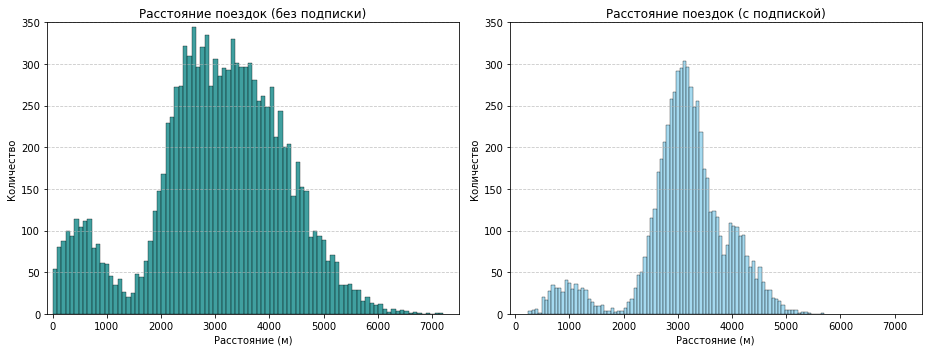

In [33]:
plt.figure(figsize=(13, 5))

# расстояние без подписки
plt.subplot(1, 2, 1)
sns.histplot(df_free['distance'], bins=90, color='teal')
plt.title('Расстояние поездок (без подписки)')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-100, 7500)
plt.ylim(0, 350)

# расстояние с подпиской
plt.subplot(1, 2, 2)
sns.histplot(df_ultra['distance'], bins=90, color='skyblue')
plt.title('Расстояние поездок (с подпиской)')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-100, 7500)
plt.ylim(0, 350)

plt.tight_layout()
plt.show()

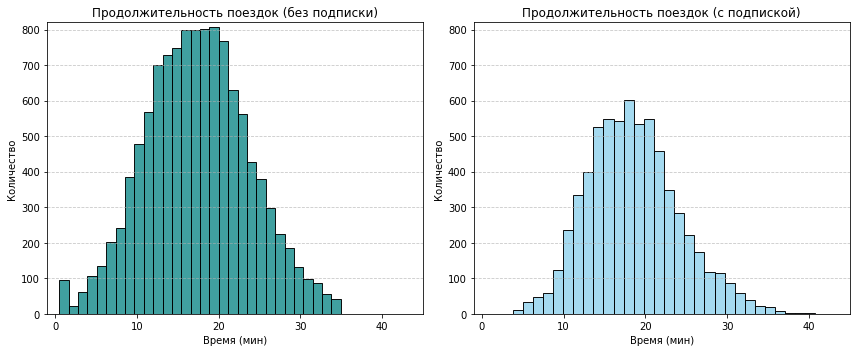

In [34]:
plt.figure(figsize=(12, 5))

# время поездки без подписки
plt.subplot(1, 2, 1)
sns.histplot(df_free['duration'], bins=30, color='teal')
plt.title('Продолжительность поездок (без подписки)')
plt.xlabel('Время (мин)')
plt.ylabel('Количество')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-1, 45)
plt.ylim(0, 820)

# время поездки с подпиской
plt.subplot(1, 2, 2)
sns.histplot(df_ultra['duration'], bins=30, color='skyblue')
plt.title('Продолжительность поездок (с подпиской)')
plt.xlabel('Время (мин)')
plt.ylabel('Количество')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(-1, 45)
plt.ylim(0, 820)

plt.tight_layout()
plt.show()

##### Выводы

**Расстояние поездок**

Основная масса поездок у пользователей без подписок на расстояние от 2 до 4,5 км, тогда как у тех, у кого есть подписки, от 2,5 до 3,5 км. Показывает что пользователи без подписок ездят чаще на расстояние больше тех кто с подпиской. Ну и поездок у них явно больше.

**Продолжительность поездок**

У пользователей без подписки большая часть поездок длится от 10 до 25 мин, у вторых же от 12 до 23 мин. Не сильно большая разница. Однако пользователи с подпиской намного меньше ездят менее 10 мин, тогда как без подписки их достаточное кол-во (примерно 300).

# Шаг 5. Подсчёт выручки

Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [35]:
aggr_df = (
    df.groupby(['user_id', 'month'], as_index=False)
    .agg(
        total_distance=('distance', 'sum'),
        ride_count=('distance', 'count'),
        total_duration=('duration', 'sum')
    )
)

aggr_df.head(20)

,user_id,month,total_distance,ride_count,total_duration
0,1,1,7027.511294,2,41.416640
1,1,4,754.159807,1,6.232113
2,1,8,6723.470560,2,44.776802
3,1,10,5809.911100,2,31.578017
4,1,11,7003.499363,3,53.397424
5,1,12,6751.629942,2,27.203912
6,2,3,10187.723006,3,60.959959
7,2,4,6164.381824,2,39.048633
8,2,6,3255.338202,1,13.851127
9,2,7,6780.722964,2,46.170157


В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.

In [36]:
# чтож, данные будем брать и изменять в объедененном датафрейме
# создадим новый столбец с округленными значениями продолжительности поездки
df['duration_ceil'] = np.ceil(df['duration'])
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,duration_ceil
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199,26.0
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199,16.0
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199,7.0
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199,19.0
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199,27.0


In [37]:
# добавим столбец с рассчетом стоимости поездки
df['ride_cost'] = df['start_ride_price'] + df['minute_price'] * df['duration_ceil']
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,duration_ceil,ride_cost
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199,26.0,156.0
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199,16.0,96.0
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199,7.0,42.0
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199,19.0,114.0
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199,27.0,162.0


In [38]:
# сгруппируем новую таблицу с новым столбцом доход за месяц
aggr_df_with_cost = (
    df.groupby(['user_id', 'month'], as_index=False)
    .agg(
        total_distance=('distance', 'sum'),
        ride_count=('distance', 'count'),
        total_duration=('duration', 'sum'),
        ride_revenue=('ride_cost', 'sum'),
        subscription_fee=('subscription_fee', 'first')
    )
    .assign(
        total_revenue=lambda x: x['ride_revenue'] + x['subscription_fee']
    )
)
aggr_df_with_cost.head(20)

,user_id,month,total_distance,ride_count,total_duration,ride_revenue,subscription_fee,total_revenue
0,1,1,7027.511294,2,41.416640,252.0,199,451.0
1,1,4,754.159807,1,6.232113,42.0,199,241.0
2,1,8,6723.470560,2,44.776802,276.0,199,475.0
3,1,10,5809.911100,2,31.578017,192.0,199,391.0
4,1,11,7003.499363,3,53.397424,336.0,199,535.0
5,1,12,6751.629942,2,27.203912,168.0,199,367.0
6,2,3,10187.723006,3,60.959959,378.0,199,577.0
7,2,4,6164.381824,2,39.048633,240.0,199,439.0
8,2,6,3255.338202,1,13.851127,84.0,199,283.0
9,2,7,6780.722964,2,46.170157,288.0,199,487.0


##### Вывод

Собран новый датафрейм с данными о помесячной выручке по каждому пользователю.

# Шаг 6. Проверка гипотез

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Определим гипотизы:

$H_0$: Среднее время поездок у пользователей с подпиской равно среднему времени поездок у пользователей без подписки.

$H_1$: Среднее время поездок у пользователей с подпиской больше , чем у пользователей без подписки.

Статестическую значимость возьмем в 5%.

In [39]:
mean_subscribers = np.mean(df_ultra['duration'])
mean_non_subscribers = np.mean(df_free['duration'])

print(f"Средняя длительность поездки у пользователей с подпиской: {mean_subscribers:.2f}")
print(f"Средняя длительность поездки у пользователей без подписки: {mean_non_subscribers:.2f}")

Средняя длительность поездки у пользователей с подпиской: 18.54
Средняя длительность поездки у пользователей без подписки: 17.39


In [40]:
alpha = 0.05

results = st.ttest_ind(
    df_ultra['duration'],
    df_free['duration'],
    alternative='greater'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


###### Вывод

Мы отвергаем нулевую гипотезу в пользу альтернативной $H_1$: Среднее время поездок у подписчиков больше , чем у пользователей без подписки.

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Определим гипотизы:

$H_0$: Среднее расстояние поездки у пользователей с подпиской не превышает 3130 метров.

$H_1$: Среднее расстояние поездки у пользователей с подпиской превышает 3130 метров.

Статестическую значимость возьмем в 5%.

In [41]:
mean_dist = np.mean(df_ultra['distance'])

print(f"Среднее расстояние поездки у пользователей с подпиской: {mean_dist:.2f}")

target_distance = 3130
alpha = 0.05

results = st.ttest_1samp(
    df_ultra['distance'],
    target_distance,
    alternative='greater'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее расстояние поездки у пользователей с подпиской: 3115.45
p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


###### Вывод

Гипотезу "Среднее расстояние поездки у пользователей с подпиской не превышает 3130 метров." не удалось опровергнуть.

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Определим гипотизы:

$H_0$: Средняя помесячная выручка от пользователей с подпиской равна средней помесячной выручке от пользователей без подписки.

$H_1$: Средняя помесячная выручка от пользователей с подпиской больше , чем у пользователей без подписки.


Статестическую значимость возьмем в 5%.

In [42]:
mean_rev_subs = np.mean(aggr_df_with_cost[aggr_df_with_cost['subscription_fee'] > 0]['total_revenue'])
mean_rev_non_subs = np.mean(aggr_df_with_cost[aggr_df_with_cost['subscription_fee'] == 0]['total_revenue'])

print(f"Средняя помесечная выручка пользователей с подпиской: {mean_rev_subs:.2f}")
print(f"Средняя помесечная выручка пользователей без подписки: {mean_rev_non_subs:.2f}")

alpha = 0.05

results = st.ttest_ind(
    aggr_df_with_cost[aggr_df_with_cost['subscription_fee'] > 0]['total_revenue'],
    aggr_df_with_cost[aggr_df_with_cost['subscription_fee'] == 0]['total_revenue'],
    alternative='greater'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Средняя помесечная выручка пользователей с подпиской: 362.79
Средняя помесечная выручка пользователей без подписки: 328.64
p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


###### Вывод

Пользователи с подпиской приносят статистически значимо большую помесячную выручку, т.к. нулевую гипотезу отвергаем.

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ**

У нас есть две парные (зависимые) выборки (одни и те же пользователи до и после обновления). Чтобы проверить гипотезу о равенстве среднего значения ген. сувокупности до и после изменений (в данном случае обновление сервера) используется парный t-тест (ttest_rel).

# Шаг 7. Распределения

##### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.  Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [43]:
p = 0.1 # вероятность продления подписки
k_min = 100 # минимум успешных продлений
alpha = 0.05 # максимальная вероятность не продления

def find_min_N(k_min, p, alpha):
#  cделаем функцию для подбора
    N = k_min  
    while True:
        prob_less = st.binom.cdf(k_min - 1, N, p)  # P(X < 100)
        if prob_less <= alpha:
            return N
        N += 1

min_N = find_min_N(k_min, p, alpha)
"Минимальное количество промокодов:", min_N

('Минимальное количество промокодов:', 1161)

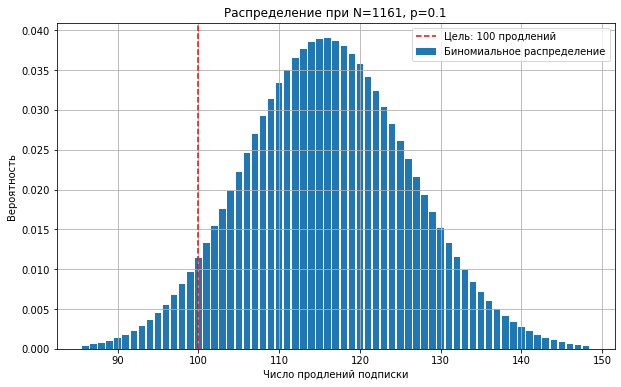

In [44]:
# диапазон возможных значений с ограничениями "хвостов"
x = np.arange(st.binom.ppf(0.001, min_N, p), st.binom.ppf(0.999, min_N, p))
y = st.binom.pmf(x, min_N, p)

# строим график
plt.figure(figsize=(10, 6))
plt.bar(x, y, label='Биномиальное распределение')
plt.axvline(x=k_min, color='red', linestyle='--', label=f'Цель: {k_min} продлений')
plt.title(f'Распределение при N={min_N}, p=0.1')
plt.xlabel('Число продлений подписки')
plt.ylabel('Вероятность')
plt.legend()
plt.grid(True)
plt.show()

**Вывод**

При вероятности не достичь цели в 100 продлений была 5%, маркетологам нужно разослать хотя бы 1161 промокодов.

##### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [45]:
n = 1000000 # кол-во уведомлений, которое планируют разослать
p = 0.4 # доля открывающих уведомления
x = 399500 # минимальное значение

mu = n * p
sigma = (n * p * (1 - p)) ** 0.5

probability = st.norm.cdf(x, mu, sigma)

print(f"Вероятность того, что уведомление откроют не более {x:,} пользователей: {probability*100:.2f}%")

Вероятность того, что уведомление откроют не более 399,500 пользователей: 15.37%
